In [1]:
import numpy as np
import xarray as xr
import gcsfs
from matplotlib import pyplot as plt
from xgcm import Grid
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import colors as cols
import scipy.special as sp
from intake import open_catalog

In [5]:
from cmocean import cm

In [30]:
plt.rcParams.update({'font.size': 16})

In [2]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
ds01  = cat["channel_ridge_resolutions_01km"].to_dask()
ds05  = cat["channel_ridge_resolutions_05km"].to_dask()
ds20  = cat["channel_ridge_resolutions_20km"].to_dask()

In [3]:
grid20 = Grid(ds20, periodic='X')
grid05 = Grid(ds05, periodic='X')
grid01 = Grid(ds01, periodic='X')

In [4]:
horispace01 = 1e3
horispace05 = 5e3
horispace20 = 20e3
time_index = 0
depth = -50
f =  -0.83e-4
daytime = 86400
alpha = 2e-4
gravity = 9.81

In [17]:
depth = 0
vort01_0 = grid01.interp(grid01.interp((grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace01

strain01_0 = ((grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))**2 + 
          (grid01.interp(grid01.interp(grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace01

div01_0 = (grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))/horispace01

In [18]:
vort01_0 = (vort01_0/f).rename('vorticity')
vort_sel = vort01_0.sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5)).isel(time=2)

<ipython-input-19-f8ced4ed2892>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, vort_sel,


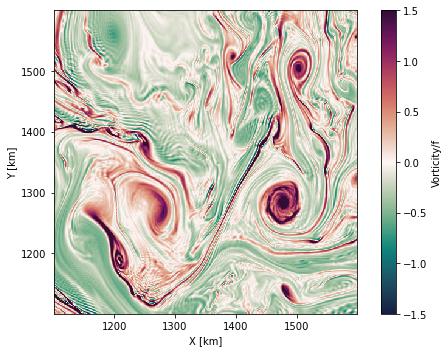

In [19]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, vort_sel, 
               vmin=-1.5, vmax=1.5, cmap=cm.curl, rasterized=True)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_aspect('equal')

# ax.set_xticks([200,400])
# ax.set_xticklabels([200, 400])
# ax.set_yticks([900, 1100])
# ax.set_yticklabels([900, 1100])

h = fig.colorbar(im, ax=ax)
h.set_label('Vorticity/f')

plt.tight_layout()


In [20]:
C_sel = ds01.PTRACER01.sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5)).sel(Z=-200, method='nearest').isel(time=2)

<ipython-input-21-899e849295cc>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, C_sel,


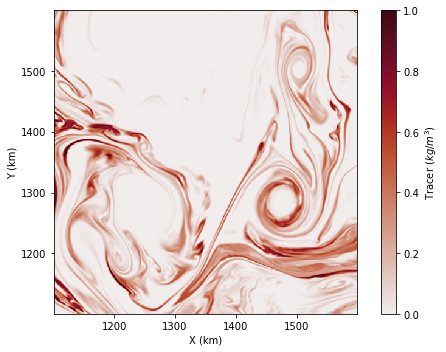

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, C_sel, 
               vmin=0, vmax=1., cmap=cm.amp, rasterized=True)
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_aspect('equal')

h = fig.colorbar(im, ax=ax)
h.set_label('Tracer ($kg/m^3$)')
plt.tight_layout()


In [ ]:


import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format



In [22]:
WC = ds01.PTRACER01*grid01.interp(ds01.W, 'Z', boundary='extend')
Wint = grid01.interp(ds01.W, 'Z', boundary='extend')

<ipython-input-25-2f22fb82b109>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, W_sel,


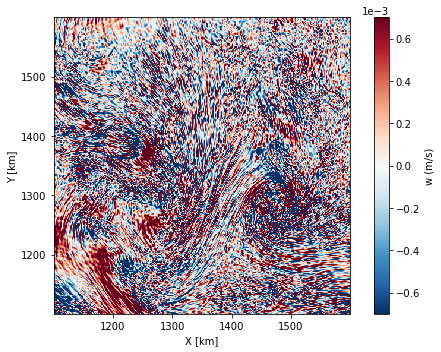

In [25]:
W_sel = Wint.sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5)).sel(Z=-200, method='nearest').isel(time=2)

fig, ax = plt.subplots(1,1, figsize=(7,5))
im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, W_sel, 
               vmin=-7e-4, vmax=7e-4, cmap='RdBu_r', rasterized=True)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_aspect('equal')
# ax.set_xticks([200,400])
# ax.set_xticklabels([200, 400])
# ax.set_yticks([900, 1100])
# ax.set_yticklabels([900, 1100])
h = fig.colorbar(im, ax=ax,format=OOMFormatter(-3, mathText=False))
h.set_label('w (m/s)')
plt.tight_layout()

In [26]:
Wbar = Wint.sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5)).sel(
    Z=-200, method='nearest').mean(['XC','YC'])

Cbar = ds01.PTRACER01.sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5)).sel(
    Z=-200, method='nearest').mean(['XC','YC'])



WpCp = WC.sel(XC = slice(11e5,16e5), YC = slice(11e5,16e5)).sel(
    Z=-200, method='nearest') - Wbar*Cbar



<ipython-input-27-efb50be2bd78>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, WpCp.isel(time=2),


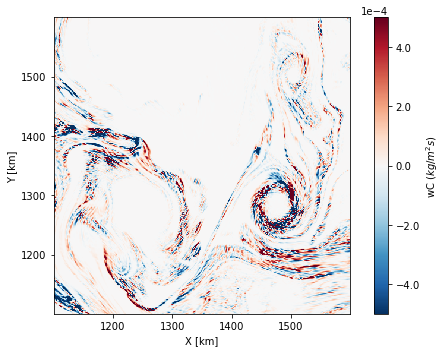

In [27]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
im = ax.pcolormesh(vort_sel.XC/1e3, vort_sel.YC/1e3, WpCp.isel(time=2), 
               vmin=-5e-4, vmax=5e-4, cmap='RdBu_r', rasterized=True)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_aspect('equal')
h = fig.colorbar(im, ax=ax,format=OOMFormatter(-4, mathText=False))
h.set_label('wC ($kg/m^2s$)')

# ax.set_xticks([200,400])
# ax.set_xticklabels([200, 400])
# ax.set_yticks([900, 1100])
# ax.set_yticklabels([900, 1100])
plt.tight_layout()

In [28]:
WpCp.load();

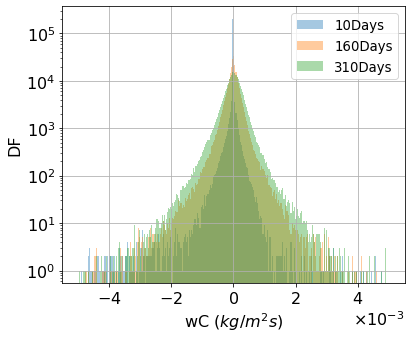

In [31]:
bins = np.linspace(-5e-3,5e-3,301)
# bins = np.linspace(-1e-3,1e-3,301)
fig, ax = plt.subplots(1,1, figsize=(6,5))

for i in range(0, 35,15 ):
    
    WpCp.isel(time=i).plot.hist(ax=ax, bins=bins, alpha=0.4, label=str(i*10+10)+'Days');

ax.ticklabel_format(style='sci',scilimits=(0,0),useMathText=True)
ax.set_yscale('log')
plt.grid()
ax.set_xlabel('wC ($kg/m^2s$)')
ax.set_ylabel('DF')
plt.legend(loc=0, fontsize='small')
plt.title('')
plt.tight_layout()

In [34]:
time = np.arange(10,360,10)

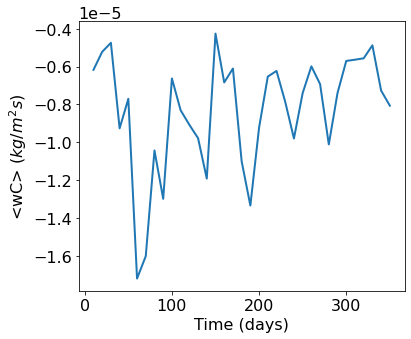

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.plot(time, WpCp.mean(['XC','YC']), linewidth=2)

ax.set_xlabel('Time (days)')
ax.set_ylabel('<wC> ($kg/m^2s$)')
plt.tight_layout()